## What types of market behavior exist?

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [73]:
import yfinance as yf

df = yf.download("^GSPC", start="2000-01-01")
df.head()


/tmp/ipython-input-1868807087.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start="2000-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


In [74]:
df.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [75]:
df.shape

(6559, 5)

In [76]:
# Fix MultiIndex columns
df.columns = df.columns.get_level_values(0)


In [77]:
# Daily Returns : How much market moved today relative to yesterday

df['return'] = df['Close'].pct_change()


In [78]:
# Rolling Volatility (Risk)

df['volatility'] = df['return'].rolling(window=14).std()


In [79]:
# Drawdown (Pain) : How far below the peak we are; Crashes = deep drawdowns

rolling_max = df['Close'].cummax()
df['drawdown'] = (df['Close'] - rolling_max) / rolling_max


In [ ]:
df = df.dropna()

In [81]:
df.shape

(6545, 8)

In [82]:
# Data Scaling

from sklearn.preprocessing import StandardScaler

# Each row = one trading day.
features = df[['return', 'volatility', 'drawdown']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


In [83]:
X_scaled.shape


(6545, 3)

Without scaling:
- Volatility dominates
- Drawdown dominates
- Return becomes irrelevant

With scaling:
- Each feature contributes equally
- Regimes actually make sense

In [84]:
 # KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df['regime'] = kmeans.fit_predict(X_scaled)


## Plot 1: Market Regimes over Time (Price Chart)

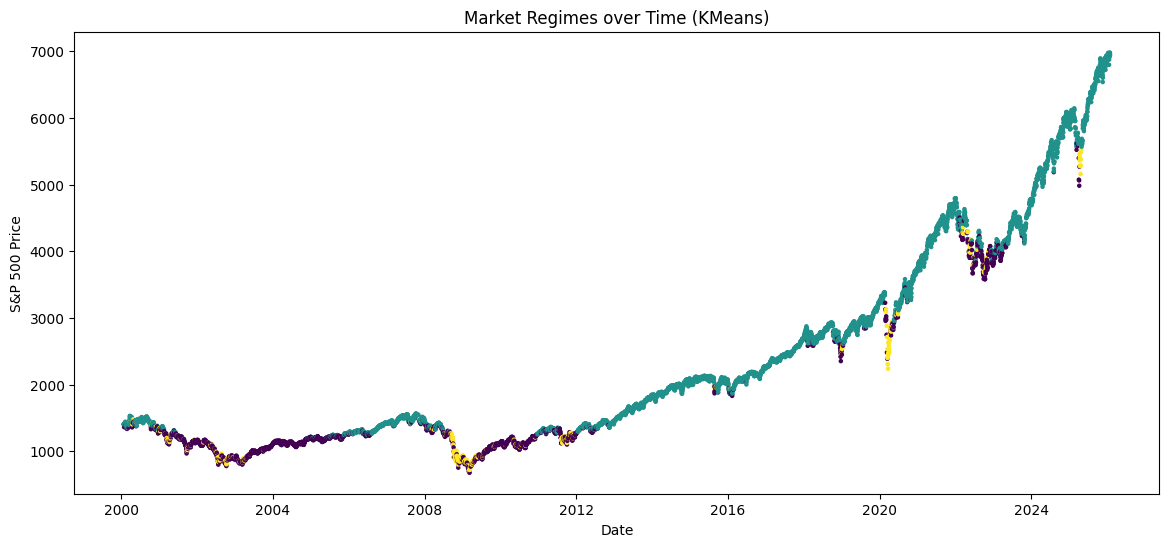

In [85]:
# Visualize Regimes on Price Chart

plt.figure(figsize=(14,6))
plt.scatter(df.index, df['Close'], c=df['regime'], cmap='viridis', s=5)
plt.title("Market Regimes over Time (KMeans)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.show()


- X-axis: Time (2000 → now)
- Y-axis: S&P 500 price

- Each dot: One trading day
- Color: Market regime (0, 1, or 2)

So the model is saying: **“On THIS day, the market behaved like Regime X”**

---
- Same-colored regions = same market behavior
- Sudden color changes = regime shifts
- Dark / clustered regions during crashes = crisis regimes

In [86]:
# Regime Statistics (Interpretation)

regime_summary = df.groupby('regime')[['return', 'volatility', 'drawdown']].mean()
regime_summary


Price,return,volatility,drawdown
regime,,,
0,-0.005762,0.011740,-0.255140
1,0.001625,0.007722,-0.047547
2,0.017992,0.025850,-0.293944


- Regime 0 → low vol, small drawdown → calm

- Regime 2 → high vol, deep drawdown → crisis

| Regime | Interpretation                                                      |
| ------ | ------------------------------------------------------------------- |
| **0**  | Mild negative returns, moderate pain → **volatile sideways market** |
| **1**  | Small positive return, low volatility → **bull / calm market**      |
| **2**  | High volatility, deep drawdowns → **crisis / crash regime**         |


## Plot 2: Volatility by Market Regime (Boxplot)


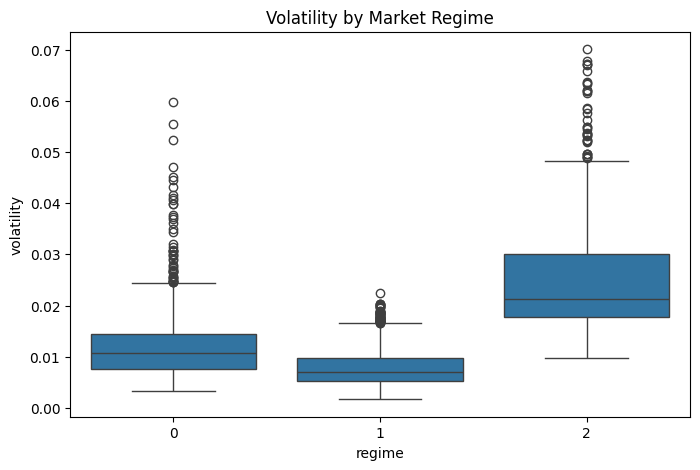

In [87]:
# Volatility Distribution per Regime

plt.figure(figsize=(8,5))
sns.boxplot(x='regime', y='volatility', data=df)
plt.title("Volatility by Market Regime")
plt.show()


For each regime:
- Median volatility
- Spread (risk)
- Outliers (panic days)

### This is how we prove the regimes are meaningful.

In [88]:
import os
os.makedirs("../outputs", exist_ok=True)


In [90]:
df[['return', 'volatility', 'drawdown', 'regime']].to_csv(
    "/content/outputs/regimes.csv",
    index=True
)

df[['return', 'volatility', 'drawdown', 'regime']].to_json(
    "/content/outputs/regimes.json",
    orient="records"
)
